In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)

In [12]:
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_qry = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
last_date = last_date_qry[0]
lastDate = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
one_year_ago = lastDate - dt.timedelta(days = 365)
print(lastDate,one_year_ago)

# Perform a query to retrieve the data and precipitation scores
raindata = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_data_df = pd.DataFrame(raindata).set_index('date')
rain_data_df = rain_data_df.rename(columns= {'prcp':'Precipitation'})
rain_data_df.head(20)


2017-08-23 2016-08-23


,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


### Precipitation Chart

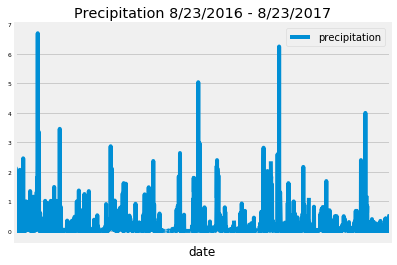

In [16]:
# Sort the dataframe by date
rain_data_df=rain_data_df.sort_index(ascending = True)
# Use Pandas Plotting with Matplotlib to plot the data
rain_data_plot = rain_data_df.plot(title='Precipitation 8/23/2016 - 8/23/2017', fontsize = 6) 
rain_data_plot.axes.get_xaxis().set_ticks([])
rain_data_plot.legend(["precipitation"])
plt.savefig("Outputs/Precipitation.png")


### Precipitation Summary Statistics

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_stat = pd.DataFrame(rain_data_df.describe())
prcp_stat

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'There is {station_count} stations available in this dataset.')

There is 9 stations available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import func
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Station with highest number of observations

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stationID = station_count[0][0]
station_name = session.query(Station.name).filter_by(station=stationID)

print(f'The most active station is {stationID}: {station_name[0][0]}.')

highest_temp_qry = session.query(Measurement.tobs, func.max(Measurement.tobs)).\
    filter_by(station = stationID).first()
highest_temp = highest_temp_qry[0]
print(f'The highest temperature in {stationID}: {station_name[0][0]} is {highest_temp} degree F.')
lowest_temp_qry = session.query(Measurement.tobs, func.min(Measurement.tobs)).\
    filter_by(station = stationID).first()
lowest_temp = lowest_temp_qry[0]
print(f'The lowest temperature in {stationID}: {station_name[0][0]} is {lowest_temp} degree F.')

avg_temp_qry = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
    filter_by(station = stationID).first()
avg_temp = avg_temp_qry[0]
print(f'The average temperature in {stationID}: {station_name[0][0]} is {avg_temp} degree F.')

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature in USC00519281: WAIHEE 837.5, HI US is 85.0 degree F.
The lowest temperature in USC00519281: WAIHEE 837.5, HI US is 54.0 degree F.
The average temperature in USC00519281: WAIHEE 837.5, HI US is 70.0 degree F.


### 12 months of temperature observation data from the most active station

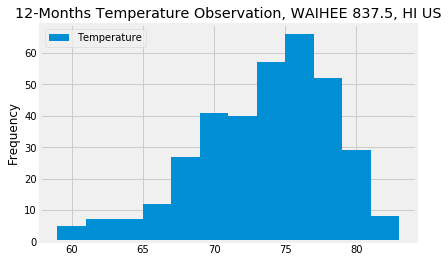

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date,Measurement.tobs).\
    filter_by(station = stationID).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

#convert query into dataframe
temp_df = pd.DataFrame(temp_data, columns = ['Date', 'Temperature']).set_index('Date')
temp_df.head()

#histogram plot with pandas
temp_df.plot(kind='hist', bins=12)
plt.title('12-Months Temperature Observation, WAIHEE 837.5, HI US')
#plt.tight_layout()
plt.savefig("Outputs/Station_Histogram.png")

# Optional

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Set trip date
tripdate = ['2019-07-27', '2019-08-10']
tripStartDate = '2017-07-27' 
tripEndDate = '2017-08-10'
trip_temp = calc_temps(tripStartDate, tripEndDate)
trip_temp

[(71.0, 79.14084507042253, 84.0)]

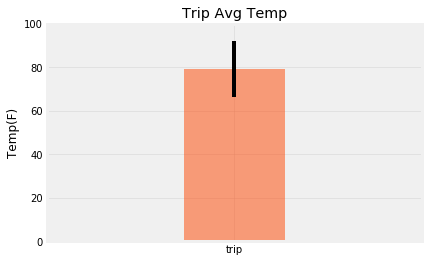

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_min = trip_temp[0][0]
trip_temp_mean = trip_temp[0][1]
trip_temp_max = trip_temp[0][2]
yerr = trip_temp_max - trip_temp_min

plt.bar('trip',trip_temp_mean, yerr = yerr, color = 'orangered', alpha = 0.5)
plt.ylim(0,100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.grid(alpha = .4)
plt.savefig("Outputs/Trip_Avg_Temp.png")

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, Station.name, func.sum(Measurement.prcp),
        Station.latitude, Station.longitude, Station.elevation])
trip_rainfall = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= tripStartDate ).filter(Measurement.date <= tripEndDate).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
trip_rainfall
trip_rainfall_df = pd.DataFrame(np.array(trip_rainfall))
trip_rainfall_df = trip_rainfall_df.rename(columns = {
                    0: 'Station ID', 1:'Station Name',
                    2: 'Total Precipitation',
                    3: 'Latitude', 4:'Longitude',
                    5: 'Elevation'})
trip_rainfall_df

,Station ID,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.9200000000000002,21.3331,-157.8025,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.48,21.5213,-157.8374,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.39,21.45167,-157.84888999999998,32.9
3,USC00513117,"KANEOHE 838.1, HI US",0.19,21.4234,-157.8015,14.6
4,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.2716,-157.8168,3.0
5,USC00517948,"PEARL CITY, HI US",0.01,21.3934,-157.9751,11.9
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip

tripStartDate = '2017-07-27' 
tripEndDate = '2017-08-10'
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = dt.datetime.strptime(tripStartDate, '%Y-%m-%d').date()
enddate = dt.datetime.strptime(tripEndDate, '%Y-%m-%d').date()
print(startdate, enddate)


# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

trip_datelist = [dt.datetime.strftime(startdate + dt.timedelta(days = x), '%Y-%m-%d')
                for x in range ((enddate-startdate).days+1)]

trip_datelist_md = [date[-5:] for date in trip_datelist]

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(date) for date in trip_datelist_md]
trip_normals

2017-07-27 2017-08-10


[[(68.0, 76.58181818181818, 83.0)],
 [(69.0, 76.46428571428571, 82.0)],
 [(69.0, 76.47058823529412, 83.0)],
 [(69.0, 77.35185185185185, 84.0)],
 [(72.0, 77.03571428571429, 83.0)],
 [(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_arr = [np.array(normal[0]) for normal in trip_normals]

trip_normals_df = pd.DataFrame(trip_normals_arr).rename(columns = {0:'Tmin', 1:'Tavg', 2:'Tmax'})
trip_normals_df['Date'] = trip_datelist
trip_normals_df = trip_normals_df.set_index('Date')
trip_normals_df

,Tmin,Tavg,Tmax
Date,,,
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0
2017-07-29,69.0,76.470588,83.0
2017-07-30,69.0,77.351852,84.0
2017-07-31,72.0,77.035714,83.0
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0


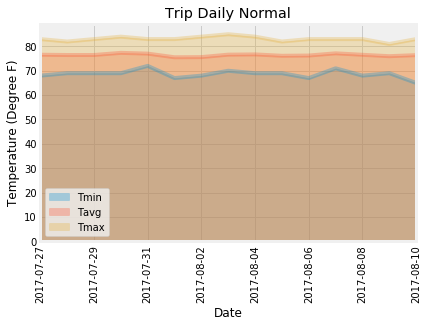

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot.area(stacked = False, alpha = 0.3)
plt.xticks(rotation = 90)
plt.ylabel("Temperature (Degree F)")
plt.title("Trip Daily Normal")
plt.savefig("Outputs/Trip_Daily_Normal.png")

## Temperature Analysis I
* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

Null Hypothesis: Temperature in June is not statistically significant different form temperature in December in Hawaii.

In [30]:
# Calculate June monthly average from all available years at each station
monthly_average_June = session.query(Measurement.station,func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).all()
June_average_df = pd.DataFrame(np.array(monthly_average_June)).\
                    rename(columns = {0: "Station", 1: "Mean Temp in June"})
June_average_df

,Station,Mean Temp in June
0,USC00511918,74.13939393939394
1,USC00513117,74.05084745762711
2,USC00514830,76.00537634408602
3,USC00516128,71.9372197309417
4,USC00517948,76.6554054054054
5,USC00518838,73.39473684210526
6,USC00519281,73.27118644067797
7,USC00519397,77.55932203389831
8,USC00519523,76.66810344827586


In [31]:
# Calculate December monthly average from all available years at each station
monthly_average_Dec = session.query(Measurement.station,func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).all()
Dec_average_df = pd.DataFrame(np.array(monthly_average_Dec)).\
                    rename(columns = {0: "Station", 1: "Mean Temp in December"})
Dec_average_df

,Station,Mean Temp in December
0,USC00511918,69.6842105263158
1,USC00513117,71.06944444444444
2,USC00514830,73.2247191011236
3,USC00516128,69.29126213592232
4,USC00517948,71.8348623853211
5,USC00518838,72.42105263157895
6,USC00519281,69.90322580645162
7,USC00519397,71.10952380952381
8,USC00519523,72.43333333333334


In [32]:
#Merge two dataframes for t-test:
mean_temp = pd.merge(June_average_df, Dec_average_df, on = ["Station"])
mean_temp

,Station,Mean Temp in June,Mean Temp in December
0,USC00511918,74.13939393939394,69.6842105263158
1,USC00513117,74.05084745762711,71.06944444444444
2,USC00514830,76.00537634408602,73.2247191011236
3,USC00516128,71.9372197309417,69.29126213592232
4,USC00517948,76.6554054054054,71.8348623853211
5,USC00518838,73.39473684210526,72.42105263157895
6,USC00519281,73.27118644067797,69.90322580645162
7,USC00519397,77.55932203389831,71.10952380952381
8,USC00519523,76.66810344827586,72.43333333333334


In [33]:
# Assign mean columns to float datatype:
mean_temp ["Mean Temp in June"] = mean_temp ["Mean Temp in June"].astype(float)
mean_temp ["Mean Temp in December"] = mean_temp ["Mean Temp in December"].astype(float)
mean_temp




,Station,Mean Temp in June,Mean Temp in December
0,USC00511918,74.139394,69.684211
1,USC00513117,74.050847,71.069444
2,USC00514830,76.005376,73.224719
3,USC00516128,71.937220,69.291262
4,USC00517948,76.655405,71.834862
5,USC00518838,73.394737,72.421053
6,USC00519281,73.271186,69.903226
7,USC00519397,77.559322,71.109524
8,USC00519523,76.668103,72.433333


In [34]:
#Perform paired t-test:
import scipy.stats as stats
stats.ttest_rel(mean_temp["Mean Temp in June"],mean_temp["Mean Temp in December"])






Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

Paired t-test was used for the analysis since two dataset have 
the same station. Temperature in each station were collected in 
June and then December, results in pairs of observations.

From the t-test, with p value of 0.0001, which is significantly < 0.05, 
null hypothesis is rejected. Therefore, the temperature in summer and winter 
are statistically significant different.

However, with the temperature remains in the upper 60 degree F and lower 70
degree F in summer and winter, the difference is not practical significance.